In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier

import contractions
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

import re
import string
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fahrizain\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fahrizain\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\fahrizain\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [119]:
def fix_contractions(text):
    fix = text
    try:
        fix = contractions.fix(text)
    except:
        pass
    return fix

def rm_link(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)
    # return re.sub(r"https?://\S+|www\.\S+", "", text)

def rm_punct(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# handle case like "shut up okay?Im only 10 years old"
# become "shut up okay Im only 10 years old"
def rm_punct2(text):
    return re.sub(r'[\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)

def rm_number(text):
    return re.sub(r'\d+', '', text)

def rm_whitespaces(text):
    return re.sub(r' +', ' ', text)

def rm_nonascii(text):
    return re.sub(r'[^\x00-\x7f]', r'', text)

def rm_emoji(text):
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)

def spell_correction(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

def clean_pipeline(text):
    text_lower = text.lower()
    fix_contr = fix_contractions(text_lower)
    no_link = rm_link(fix_contr)
    no_punct = rm_punct2(no_link)
    # no_number = rm_number(no_punct)
    no_whitespaces = rm_whitespaces(no_punct)
    no_nonasci = rm_nonascii(no_whitespaces)
    no_emoji = rm_emoji(no_nonasci)
    spell_corrected = spell_correction(no_emoji)
    return spell_corrected

In [113]:
def tokenize(text):
    return word_tokenize(text)

def rm_stopwords(text):
    return [i for i in text if i not in stopwords]

def postag(text):
    # not implemented yet
    return

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()    
    lemmas = [lemmatizer.lemmatize(t) for t in text]
    # make sure lemmas does not contains sotpwords
    return rm_stopwords(lemmas)

def preprocess_pipeline(text):
    tokens = tokenize(text)
    no_stopwords = rm_stopwords(tokens)
    lemmas = lemmatize(no_stopwords)
    if len(lemmas) <= 0:
        return text
    return ' '.join(lemmas)

In [177]:
train = pd.read_csv('../data/raw/jigsaw/train.csv')
test = pd.read_csv('../data/raw/jigsaw/test.csv')
test_label = pd.read_csv('../data/raw/jigsaw/test_labels.csv')

test = test.merge(test_label, how='inner', on='id')

len(train), len(test), len(test_label)

(159571, 153164, 153164)

In [178]:
def is_toxic(row):
    return 1 if row.sum() > 1 else -1 if row.sum() < 0 else 0

train['is_toxic'] = train.iloc[:, 2:].apply(is_toxic, axis=1)
test['is_toxic'] = test.iloc[:, 2:].apply(is_toxic, axis=1)

In [188]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [189]:
train['clean'] = train.comment_text.apply(clean_pipeline)
train.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_toxic,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,explanation\nwhy the edits made under my usern...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,d aww he matches this background colour i am s...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,hey man i am really not trying to edit war it ...


In [190]:
train[train['clean'] != ''].count()

id               159567
comment_text     159567
toxic            159567
severe_toxic     159567
obscene          159567
threat           159567
insult           159567
identity_hate    159567
is_toxic         159567
clean            159567
dtype: int64

In [191]:
train = train[train['clean'] != '']

train['processed'] = train.clean.apply(preprocess_pipeline)
train.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_toxic,clean,processed
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,explanation\nwhy the edits made under my usern...,explanation edits made username hardcore metal...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,d aww he matches this background colour i am s...,aww match background colour seemingly stuck th...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,hey man i am really not trying to edit war it ...,hey man really trying edit war guy constantly ...


In [192]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159567 entries, 0 to 159570
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159567 non-null  object
 1   comment_text   159567 non-null  object
 2   toxic          159567 non-null  int64 
 3   severe_toxic   159567 non-null  int64 
 4   obscene        159567 non-null  int64 
 5   threat         159567 non-null  int64 
 6   insult         159567 non-null  int64 
 7   identity_hate  159567 non-null  int64 
 8   is_toxic       159567 non-null  int64 
 9   clean          159567 non-null  object
 10  processed      159567 non-null  object
dtypes: int64(7), object(4)
memory usage: 14.6+ MB


## Feature Extraction

In [193]:
toxvocab = pd.read_csv('../data/processed/toxvocab_jigsaw_keep_number.csv')
toxvocab.sort_values(by='weight', ascending=False).head()

,token,weight,occurence
8780,oxymoron83,6.388438,176.0
1924,bunksteve,6.337069,278.0
3244,derka,5.599605,141.0
8006,motherfucker,5.060153,619.0
4796,fuck,4.676083,16619.0


In [194]:
toxvocab_dict = dict(zip(toxvocab['token'],toxvocab['weight']))

In [195]:
type(toxvocab_dict['007'])

float

In [196]:
def toxic_occurrence(text, vocab):
    stext = text.split()
    occur = 0
    for t in stext:
        if t in vocab:
            occur += 1

    return occur

def toxic_weight_rate(text, vocab):
    stext = text.split()
    toxic_rate = []
    for t in stext:
        if t in vocab:
            toxic_rate = np.append(toxic_rate, vocab[t])
    try:
        return np.mean(toxic_rate) if len(toxic_rate) > 0 else 0
    except:
        print(text)
        print(toxic_rate)
        

In [197]:
tqdm.pandas()
train['tox_occur'] = train.processed.progress_apply(toxic_occurrence, args=(toxvocab_dict, ))
train['tox_rate'] = train.processed.progress_apply(toxic_weight_rate, args=(toxvocab_dict, ))

100%|██████████| 159567/159567 [00:08<00:00, 19557.52it/s]


In [198]:
train.sort_values(by=['tox_rate'], ascending=False).head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_toxic,clean,processed,tox_occur,tox_rate
53408,8ecc71e2dd4e2fbe,BunkSteve is gay! BunkSteve is gay! BunkSteve ...,1,1,0,0,1,1,1,bunksteve is gay bunksteve is gay bunksteve is...,bunksteve gay bunksteve gay bunksteve gay bunk...,278,6.337069
116477,6ea1aefc9a6cc945,JUSTIFY YOUR CHANGES MOTHERFUCKER,1,0,1,0,1,0,1,justify your changes motherfucker,justify change motherfucker,1,5.060153
42090,704cd990f266ef15,bad motherfuckers \n\nThere are a lot of them ...,1,0,1,0,1,0,1,bad motherfuckers \n\nthere are a lot of them ...,bad motherfucker lot keep calm carry,1,5.060153


In [199]:
train.to_csv('../data/processed/trainset-feature-extracted.csv', index=None)

In [200]:
tqdm.pandas()
test['clean'] = test.comment_text.progress_apply(clean_pipeline)
test['processed'] = test.clean.progress_apply(preprocess_pipeline)
test['tox_occur'] = test.processed.progress_apply(toxic_occurrence, args=(toxvocab_dict, ))
test['tox_rate'] = test.processed.progress_apply(toxic_weight_rate, args=(toxvocab_dict, ))

100%|██████████| 153164/153164 [00:08<00:00, 18137.80it/s]


In [201]:
test = test[test['clean'] != '']

In [202]:
test.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_toxic,clean,processed,tox_occur,tox_rate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1,-1,yo bitch ja rule is more succesful then you wi...,yo bitch ja rule succesful ever hating sad mof...,18,1.080360
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1,-1,from rfc \n\n the title is fine as it is i am...,rfc title fine going,1,0.387126
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1,-1,\n\n sources \n\n zawe ashton on lapland,source zawe ashton lapland,0,0.000000


In [203]:
test.to_csv('../data/processed/testset-feature-extracted.csv', index=None, header=True)

### Read from checkpoint extracted features

In [204]:
train = pd.read_csv('../data/processed/trainset-feature-extracted.csv')
test = pd.read_csv('../data/processed/testset-feature-extracted.csv')

In [205]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159567 entries, 0 to 159566
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             159567 non-null  object 
 1   comment_text   159567 non-null  object 
 2   toxic          159567 non-null  int64  
 3   severe_toxic   159567 non-null  int64  
 4   obscene        159567 non-null  int64  
 5   threat         159567 non-null  int64  
 6   insult         159567 non-null  int64  
 7   identity_hate  159567 non-null  int64  
 8   is_toxic       159567 non-null  int64  
 9   clean          159567 non-null  object 
 10  processed      159567 non-null  object 
 11  tox_occur      159567 non-null  int64  
 12  tox_rate       159567 non-null  float64
dtypes: float64(1), int64(8), object(4)
memory usage: 15.8+ MB


In [206]:
X = train.iloc[:, -3:]
y = train.is_toxic

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=42, stratify=y)

In [207]:
X_train.head(2)

,processed,tox_occur,tox_rate
5644,yep ww past several month uploading new photo ...,1,0.417116
134682,nipple nipple nipple nipple nipple nipple nipp...,709,0.941702


In [208]:
coltrans = ColumnTransformer(
    [('vectorizer', TfidfVectorizer(), 'processed')],
    remainder='passthrough'
)
coltrans

ColumnTransformer(remainder='passthrough',
                  transformers=[('vectorizer', TfidfVectorizer(), 'processed')])

In [209]:
X_train = coltrans.fit_transform(X_train)
X_val = coltrans.transform(X_val)

## Modelling

In [210]:
# logistic regression
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     37426
           1       0.87      0.62      0.73      2466

    accuracy                           0.97     39892
   macro avg       0.92      0.81      0.85     39892
weighted avg       0.97      0.97      0.97     39892



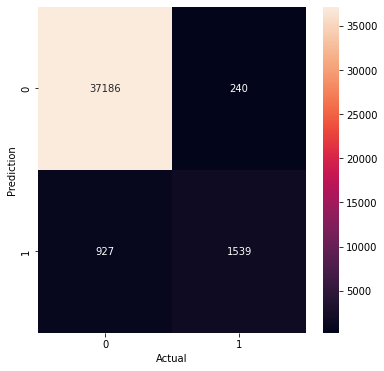

In [211]:
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Prediction')
plt.xlabel('Actual')
plt.show()

In [212]:
# XGBoost
xgb = XGBClassifier(n_estimators=100, max_depth=10, learning_rate=2e-5, random_state=42)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     37426
           1       0.77      0.70      0.74      2466

    accuracy                           0.97     39892
   macro avg       0.88      0.85      0.86     39892
weighted avg       0.97      0.97      0.97     39892



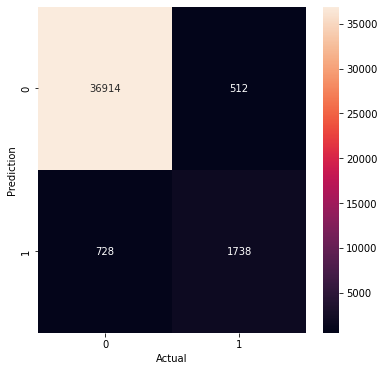

In [213]:
cm_xgb = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm_xgb, annot=True, fmt='d')
plt.ylabel('Prediction')
plt.xlabel('Actual')
plt.show()

## Inference

In [219]:
# filter test data since data with label -1 isn't used for scoring
d_test = test[test['is_toxic'] > -1]
d_test.is_toxic.value_counts()

0    59574
1     4401
Name: is_toxic, dtype: int64

In [222]:
X_test = d_test.iloc[:, -3:]
y_test = d_test.is_toxic

In [223]:
X_test = coltrans.transform(X_test)
X_test

<63975x137999 sparse matrix of type '<class 'numpy.float64'>'
	with 1656832 stored elements in Compressed Sparse Row format>

In [224]:
# logistic regression
y_pred_lr = lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     59574
           1       0.64      0.65      0.65      4401

    accuracy                           0.95     63975
   macro avg       0.81      0.81      0.81     63975
weighted avg       0.95      0.95      0.95     63975



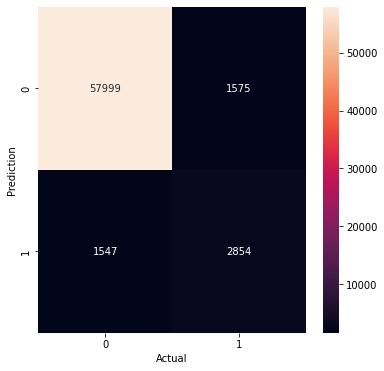

In [225]:
cm_test_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6,6))
sns.heatmap(cm_test_lr, annot=True, fmt='d')
plt.ylabel('Prediction')
plt.xlabel('Actual')
plt.show()

In [226]:
# xgboost
y_pred_xgb = xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     59574
           1       0.56      0.71      0.63      4401

    accuracy                           0.94     63975
   macro avg       0.77      0.84      0.80     63975
weighted avg       0.95      0.94      0.94     63975



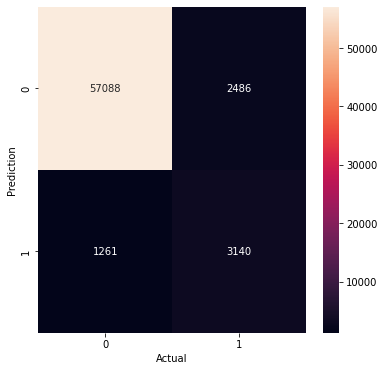

In [227]:
cm_test_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6,6))
sns.heatmap(cm_test_xgb, annot=True, fmt='d')
plt.ylabel('Prediction')
plt.xlabel('Actual')
plt.show()